# Projet Deep Learning - Prédiction de la Production Éolienne (Engie)

**Fait par :** Badreddine Saadioui & Nabil Ramdani

**Modèles :**
- Ridge Regression (linéaire)
- XGBoost (arbres)
- DNN baseline (Keras)
- DNN optimisé (Keras Tuner)

In [ ]:
pip install xgboost keras-t uner tensorflow scikit-learn pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import keras_tuner as kt

---
## 1. Chargement des données

In [7]:
# Chargement des fichiers CSV
df_X = y = pd.read_csv("engie_X.csv", sep=";")
df_Y = pd.read_csv("engie_Y.csv", sep=";")

print(f"Dimensions de X : {df_X.shape}")
print(f"Dimensions de Y : {df_Y.shape}")

# Fusion des deux fichiers sur ID
df = df_X.merge(df_Y, on='ID', how='inner')
print(f"\nDimensions du dataset fusionne : {df.shape}")
df.head()

Dimensions de X : (617386, 78)
Dimensions de Y : (617386, 2)

Dimensions du dataset fusionne : (617386, 79)


,ID,MAC_CODE,Date_time,Pitch_angle,Pitch_angle_min,Pitch_angle_max,Pitch_angle_std,Hub_temperature,Hub_temperature_min,Hub_temperature_max,...,Rotor_speed_min,Rotor_speed_max,Rotor_speed_std,Rotor_bearing_temperature,Rotor_bearing_temperature_min,Rotor_bearing_temperature_max,Rotor_bearing_temperature_std,Absolute_wind_direction_c,Nacelle_angle_c,TARGET
0,1,WT3,1.0,92.470001,92.470001,92.470001,0.0,7.00,7.0,7.0,...,0.0,0.0,0.0,2.4,2.4,2.4,0.0,294.19000,294.23999,-0.703
1,2,WT3,2.0,92.470001,92.470001,92.470001,0.0,7.00,7.0,7.0,...,0.0,0.0,0.0,2.4,2.4,2.4,0.0,297.82999,294.23999,-0.747
2,3,WT3,3.0,92.470001,92.470001,92.470001,0.0,7.00,7.0,7.0,...,0.0,0.0,0.0,2.4,2.4,2.4,0.0,322.20999,294.23999,-0.791
3,4,WT3,4.0,92.470001,92.470001,92.470001,0.0,6.97,6.7,7.0,...,0.0,0.0,0.0,2.4,2.4,2.4,0.0,318.69000,294.23999,-0.736
4,5,WT3,5.0,92.470001,92.470001,92.470001,0.0,6.93,6.0,7.0,...,0.0,0.0,0.0,2.4,2.4,2.5,0.0,314.89001,294.23999,-1.055


In [8]:
# Types de données et Analyse descriptive
print(f"Types de colonnes :\n{df.dtypes.value_counts()}")
print(f"\nColonnes : {list(df.columns[:])}")
df.describe()

Types de colonnes :
float64    77
int64       1
object      1
Name: count, dtype: int64

Colonnes : ['ID', 'MAC_CODE', 'Date_time', 'Pitch_angle', 'Pitch_angle_min', 'Pitch_angle_max', 'Pitch_angle_std', 'Hub_temperature', 'Hub_temperature_min', 'Hub_temperature_max', 'Hub_temperature_std', 'Generator_converter_speed', 'Generator_converter_speed_min', 'Generator_converter_speed_max', 'Generator_converter_speed_std', 'Generator_speed', 'Generator_speed_min', 'Generator_speed_max', 'Generator_speed_std', 'Generator_bearing_1_temperature', 'Generator_bearing_1_temperature_min', 'Generator_bearing_1_temperature_max', 'Generator_bearing_1_temperature_std', 'Generator_bearing_2_temperature', 'Generator_bearing_2_temperature_min', 'Generator_bearing_2_temperature_max', 'Generator_bearing_2_temperature_std', 'Generator_stator_temperature', 'Generator_stator_temperature_min', 'Generator_stator_temperature_max', 'Generator_stator_temperature_std', 'Gearbox_bearing_1_temperature', 'Gearbox_bearin

,ID,Date_time,Pitch_angle,Pitch_angle_min,Pitch_angle_max,Pitch_angle_std,Hub_temperature,Hub_temperature_min,Hub_temperature_max,Hub_temperature_std,...,Rotor_speed_min,Rotor_speed_max,Rotor_speed_std,Rotor_bearing_temperature,Rotor_bearing_temperature_min,Rotor_bearing_temperature_max,Rotor_bearing_temperature_std,Absolute_wind_direction_c,Nacelle_angle_c,TARGET
count,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,...,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.000000,617386.00000,617314.000000,617314.000000,617386.000000
mean,308693.500000,79862.855363,13.011933,11.798694,14.547896,0.948836,19.148534,18.940682,19.356001,0.106900,...,8.975613,11.209560,0.602339,28.417645,28.319655,28.503478,0.04733,174.828981,175.538522,372.752158
std,178224.130984,45185.110967,27.237490,27.054199,28.005869,4.208172,6.601252,6.625706,6.600733,0.156876,...,5.439411,6.004410,0.764589,7.257950,7.265970,7.290289,0.13126,96.087881,96.773179,468.001341
min,1.000000,1.000000,-156.179990,-179.570010,-146.280000,0.000000,-4.000000,-5.000000,-3.000000,0.000000,...,0.000000,0.000000,0.000000,-5.200000,-5.200000,-5.100000,0.00000,0.000000,0.000000,-19.479999
25%,154347.250000,41154.000000,-1.000000,-1.010000,-1.000000,0.000000,14.000000,14.000000,14.000000,0.000000,...,8.700000,8.870000,0.120000,25.600000,25.500000,25.700001,0.02000,80.669998,79.660004,18.624000
50%,308693.500000,80145.000000,-1.000000,-1.000000,-1.000000,0.000000,19.990000,19.200001,20.000000,0.000000,...,9.720000,12.540000,0.360000,29.600000,29.500000,29.700001,0.04000,191.740010,193.270000,193.985989
75%,463039.750000,119014.000000,5.567500,-0.980000,15.900000,0.000000,24.000000,24.000000,24.000000,0.210000,...,12.950000,16.760000,0.820000,33.009998,32.900002,33.099998,0.07000,245.810000,248.030000,540.684000
max,617386.000000,157680.000000,156.820010,175.929990,175.929990,94.769997,37.080002,37.000000,38.000000,1.240000,...,17.110001,19.709999,8.470000,67.669998,53.500000,393.799990,98.57000,360.000000,360.000000,2256.057110



## 2. Analyse Exploratoire des Données :

In [9]:
# Analyse des valeurs manquantes
missing_df = df.isnull().sum().to_frame(name="Nbs de Valeurs manquantes")
missing_df["Pourcentage (%)"] = df.isnull().mean() * 100

missing_df = (
    missing_df
    .rename(columns={"index": "Colonne"})
    .query("`Nbs de Valeurs manquantes` > 0")
    .sort_values("Pourcentage (%)", ascending=False)
)

missing_df.head(20)


,Nbs de Valeurs manquantes,Pourcentage (%)
Grid_voltage,101322,16.411451
Grid_voltage_min,101322,16.411451
Grid_voltage_max,101322,16.411451
Grid_voltage_std,101322,16.411451
Generator_converter_speed,8064,1.306152
Generator_converter_speed_min,8064,1.306152
Gearbox_inlet_temperature_min,8064,1.306152
Gearbox_inlet_temperature,8064,1.306152
Generator_converter_speed_std,8064,1.306152
Generator_converter_speed_max,8064,1.306152


In [10]:
# Statistiques descriptives de la variable cible
print("Statistiques de la variable cible (TARGET - Puissance Active) :")
print(df['TARGET'].describe())

Statistiques de la variable cible (TARGET - Puissance Active) :
count    617386.000000
mean        372.752158
std         468.001341
min         -19.479999
25%          18.624000
50%         193.985989
75%         540.684000
max        2256.057110
Name: TARGET, dtype: float64


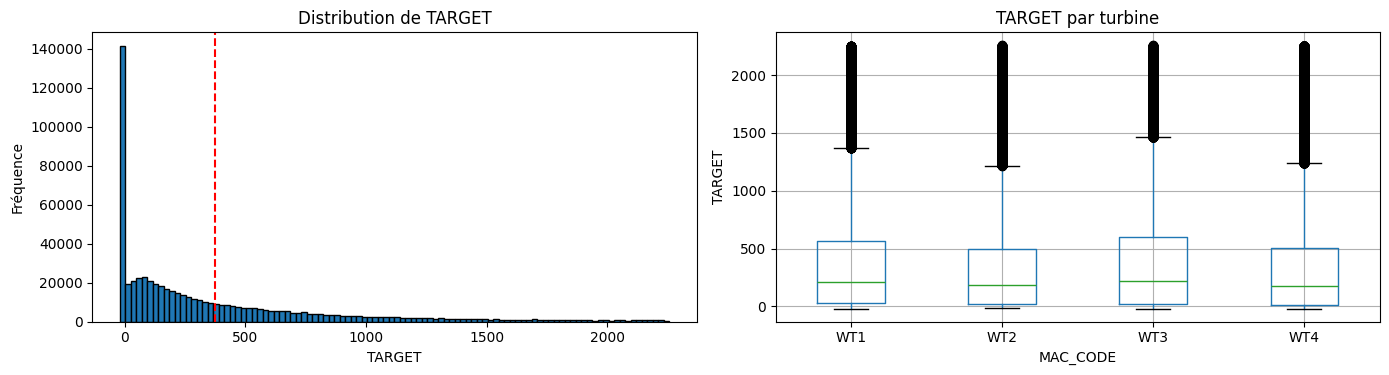

In [11]:
# Visualisation de la variable cible (distribution globale + par turbine)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df["TARGET"], bins=100, edgecolor="black")
axes[0].axvline(df["TARGET"].mean(), linestyle="--", color="red")
axes[0].set_title("Distribution de TARGET")
axes[0].set_xlabel("TARGET")
axes[0].set_ylabel("Fréquence")

df.boxplot(column="TARGET", by="MAC_CODE", ax=axes[1])
axes[1].set_title("TARGET par turbine")
axes[1].set_xlabel("MAC_CODE")
axes[1].set_ylabel("TARGET")

plt.suptitle("")
plt.tight_layout()
plt.show()


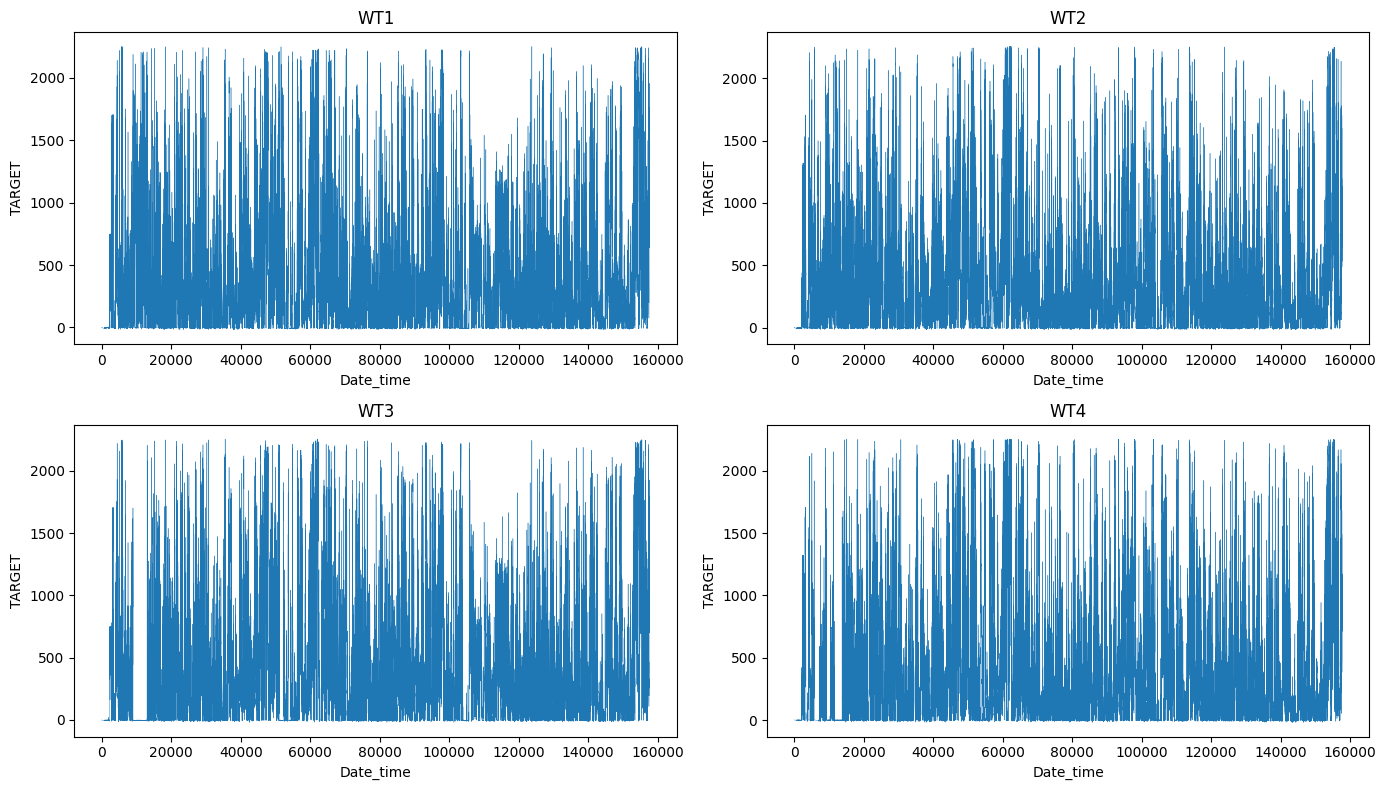

In [12]:
# Évolution temporelle de la puissance par turbine

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, wt in zip(axes.ravel(), ["WT1", "WT2", "WT3", "WT4"]):
    data_wt = df[df["MAC_CODE"] == wt].sort_values("Date_time")
    ax.plot(data_wt["Date_time"], data_wt["TARGET"], linewidth=0.3)
    ax.set_title(wt)
    ax.set_xlabel("Date_time")
    ax.set_ylabel("TARGET")

plt.tight_layout()
plt.show()

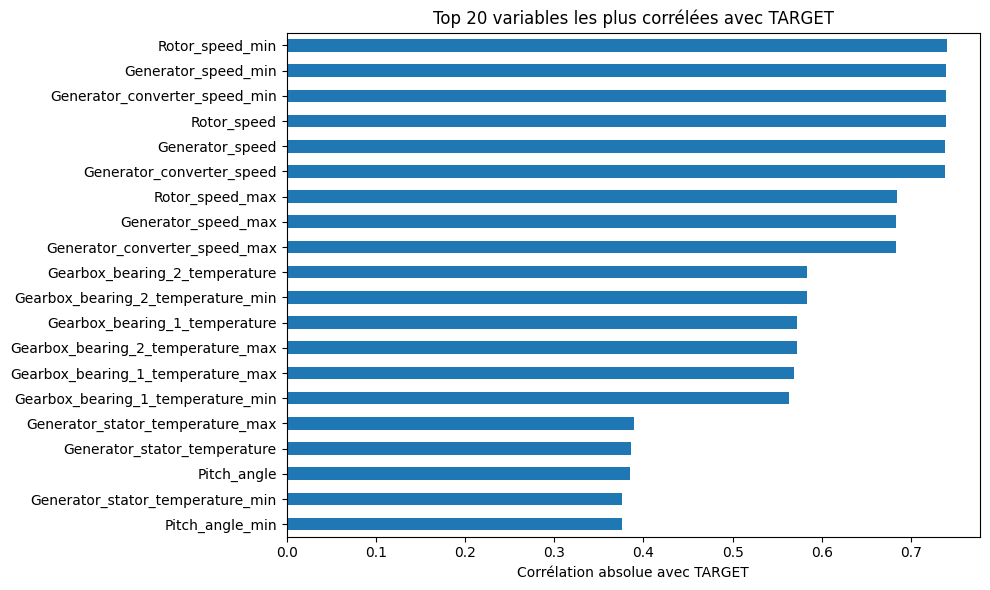

In [13]:
# Corrélation des variables numériques avec la variable cible

numeric_cols = (
    df.select_dtypes(include="number")
      .drop(columns=["ID", "Date_time"])
      .columns
)

top_features = (
    df[numeric_cols]
    .corr()["TARGET"]
    .drop("TARGET")
    .abs()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh")
plt.xlabel("Corrélation absolue avec TARGET")
plt.title("Top 20 variables les plus corrélées avec TARGET")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("top_correlations.png", dpi=150, bbox_inches="tight")
plt.show()


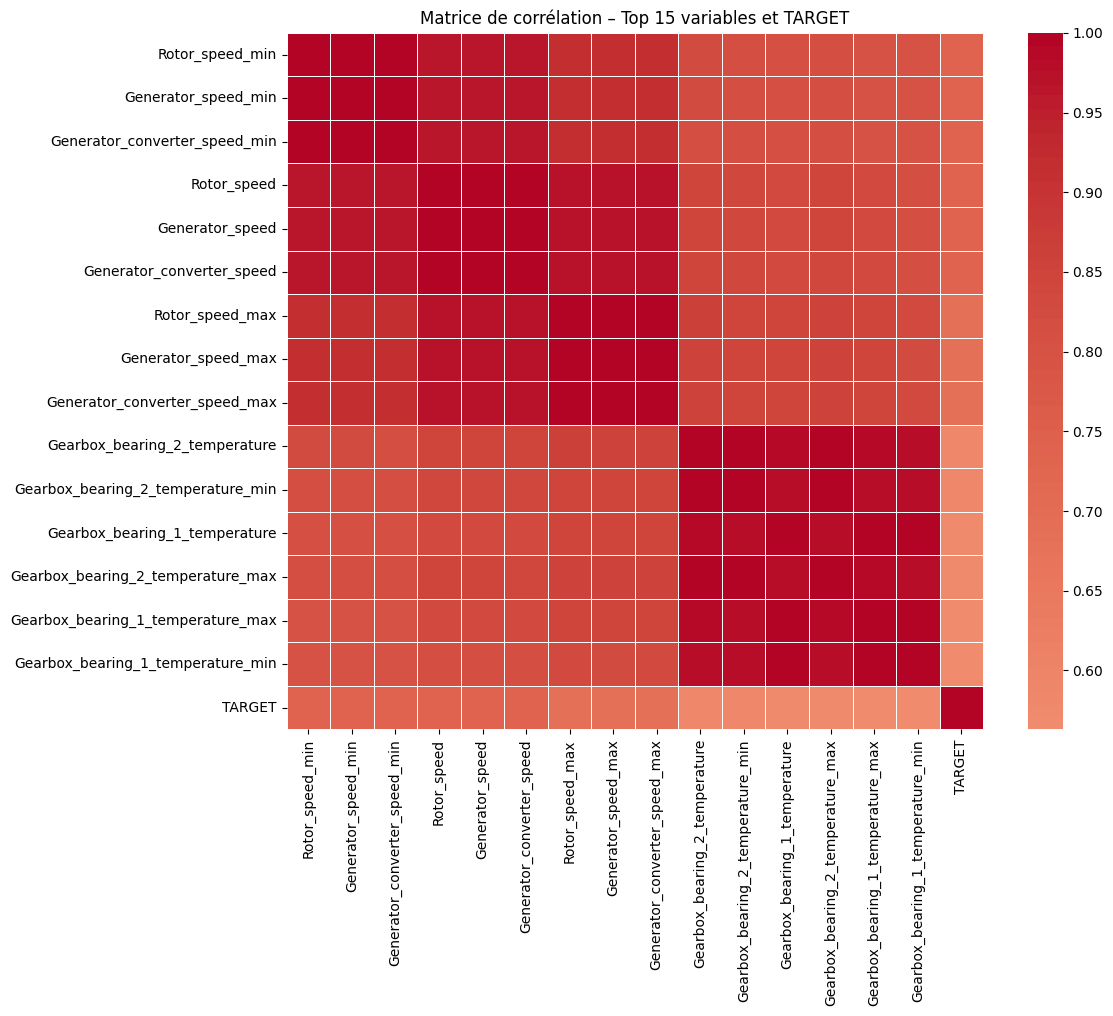

In [14]:
# Heatmap de corrélation

top_feat_names = list(top_features.index[:15]) + ["TARGET"]

plt.figure(figsize=(12, 10))
sns.heatmap(
    df[top_feat_names].corr(),
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Matrice de corrélation – Top 15 variables et TARGET")
plt.tight_layout()
plt.savefig("heatmap_correlation.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 3. Prétraitement des données

In [15]:
# Gestion des valeurs manquantes (par médiane de chaque turbine)
data = df.copy()

numeric_cols_to_impute = data.select_dtypes(include=[np.number]).columns
numeric_cols_to_impute = [c for c in numeric_cols_to_impute if c not in ['ID', 'Date_time', 'TARGET']]

for col in numeric_cols_to_impute:
    if data[col].isnull().any():
        data[col] = data.groupby('MAC_CODE')[col].transform(lambda x: x.fillna(x.median()))

remaining_na = data.isnull().sum().sum()
print(f"Valeurs manquantes restantes : {remaining_na}")
print(f"Shape après nettoyage : {data.shape}")

Valeurs manquantes restantes : 0
Shape après nettoyage : (617386, 79)


In [16]:
# Encodage de MAC_CODE (one-hot encoding)
data = pd.get_dummies(data, columns=['MAC_CODE'], prefix='turbine', dtype=int)
print(f"Colonnes turbine ajoutees : {[c for c in data.columns if c.startswith('turbine_')]}")
print(f"Shape apres encodage : {data.shape}")

Colonnes turbine ajoutees : ['turbine_WT1', 'turbine_WT2', 'turbine_WT3', 'turbine_WT4']
Shape apres encodage : (617386, 82)


In [17]:
# Split temporel : train 70% / validation 15% / test 15%

data = data.sort_values("Date_time").reset_index(drop=True)

n = len(data)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]


cols_to_exclude = ["ID", "Date_time", "TARGET"]
feature_cols = [c for c in data.columns if c not in cols_to_exclude]

X_train = train_data[feature_cols].values
y_train = train_data["TARGET"].values

X_val = val_data[feature_cols].values
y_val = val_data["TARGET"].values

X_test = test_data[feature_cols].values
y_test = test_data["TARGET"].values


print(f"Taille train : {len(train_data):,} ({len(train_data)/n*100:.1f}%)")
print(f"Taille val   : {len(val_data):,} ({len(val_data)/n*100:.1f}%)")
print(f"Taille test  : {len(test_data):,} ({len(test_data)/n*100:.1f}%)")

print(f"\nNombre de features : {len(feature_cols)}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val  : {X_val.shape}, y_val  : {y_val.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")


Taille train : 432,170 (70.0%)
Taille val   : 92,608 (15.0%)
Taille test  : 92,608 (15.0%)

Nombre de features : 79
X_train: (432170, 79), y_train: (432170,)
X_val  : (92608, 79), y_val  : (92608,)
X_test : (92608, 79), y_test : (92608,)


In [18]:
# Standardisation des variables explicatives

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


---
## 4. Modèles de Machine Learning

### 4.1 Ridge Regression (modèle linéaire)

In [22]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)


In [23]:
# Fonction pour l'évaluation des performances des modèles
results = {}

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }


In [24]:
# Entrainement de Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [25]:
# Evaluation de Ridge Regression
y_pred_ridge = ridge.predict(X_test_scaled)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)

{'MAE': 91.88797134735071,
 'RMSE': np.float64(126.33550430519799),
 'R2': 0.9381119568923727}

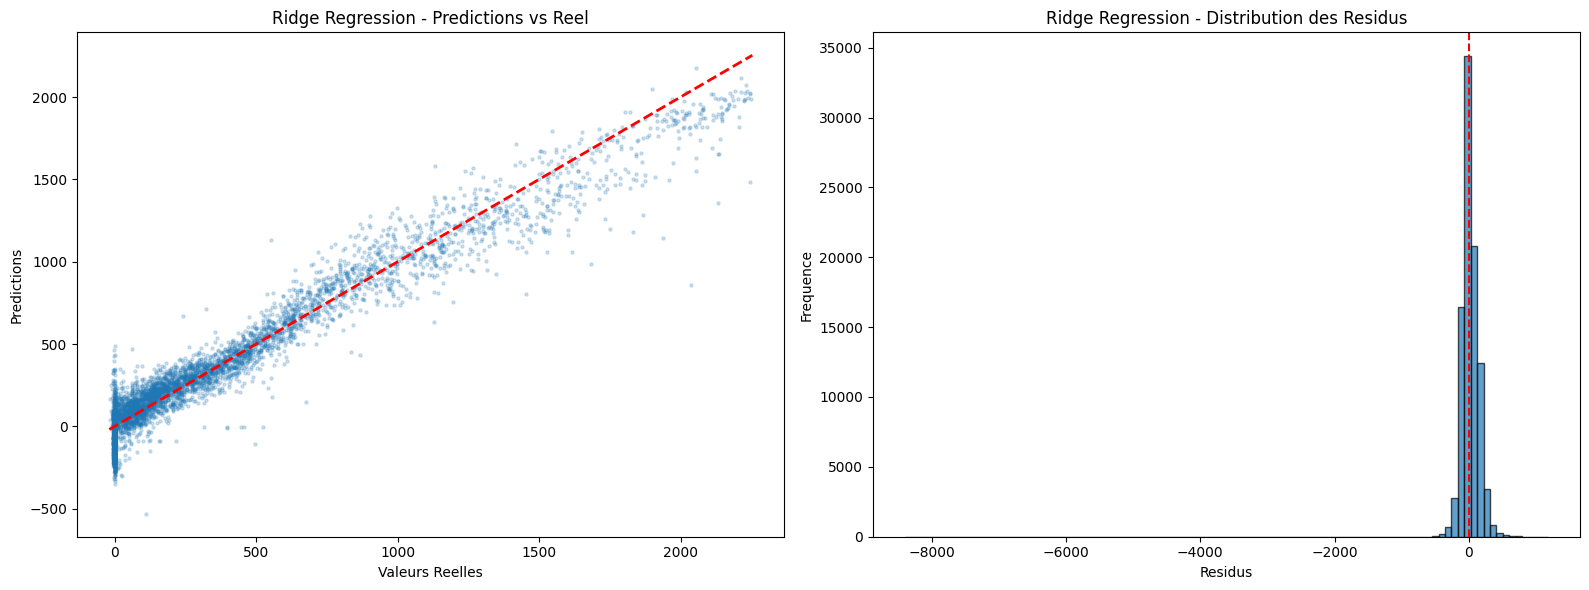

In [26]:
# Visualisation Ridge
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predictions vs Reel
sample_idx = np.random.choice(len(y_test), size=min(5000, len(y_test)), replace=False)
axes[0].scatter(y_test[sample_idx], y_pred_ridge[sample_idx], alpha=0.2, s=5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valeurs Reelles')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Ridge Regression - Predictions vs Reel')

# Distribution des residus
residuals = y_test - y_pred_ridge
axes[1].hist(residuals, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residus')
axes[1].set_ylabel('Frequence')
axes[1].set_title('Ridge Regression - Distribution des Residus')
axes[1].axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.savefig('ridge_results.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 XGBoost (modèle à base d'arbres boostés)

In [27]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae"
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)


[0]	validation_0-mae:295.75787
[1]	validation_0-mae:280.79609
[2]	validation_0-mae:266.47831
[3]	validation_0-mae:252.99630
[4]	validation_0-mae:240.23176
[5]	validation_0-mae:228.01507
[6]	validation_0-mae:216.46908
[7]	validation_0-mae:205.56771
[8]	validation_0-mae:195.16898
[9]	validation_0-mae:185.28547
[10]	validation_0-mae:175.89188
[11]	validation_0-mae:166.88777
[12]	validation_0-mae:158.45077
[13]	validation_0-mae:150.44449
[14]	validation_0-mae:142.91342
[15]	validation_0-mae:135.75082
[16]	validation_0-mae:128.94931
[17]	validation_0-mae:122.54492
[18]	validation_0-mae:116.46093
[19]	validation_0-mae:110.68312
[20]	validation_0-mae:105.25646
[21]	validation_0-mae:100.08404
[22]	validation_0-mae:95.17768
[23]	validation_0-mae:90.53030
[24]	validation_0-mae:86.14707
[25]	validation_0-mae:81.98789
[26]	validation_0-mae:78.06537
[27]	validation_0-mae:74.34137
[28]	validation_0-mae:70.82486
[29]	validation_0-mae:67.48339
[30]	validation_0-mae:64.32989
[31]	validation_0-mae:61.33

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mae'


In [28]:
# Evaluation de XGBoost
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)

{'MAE': 12.477919994218711,
 'RMSE': np.float64(29.38068886097339),
 'R2': 0.9966528138788807}

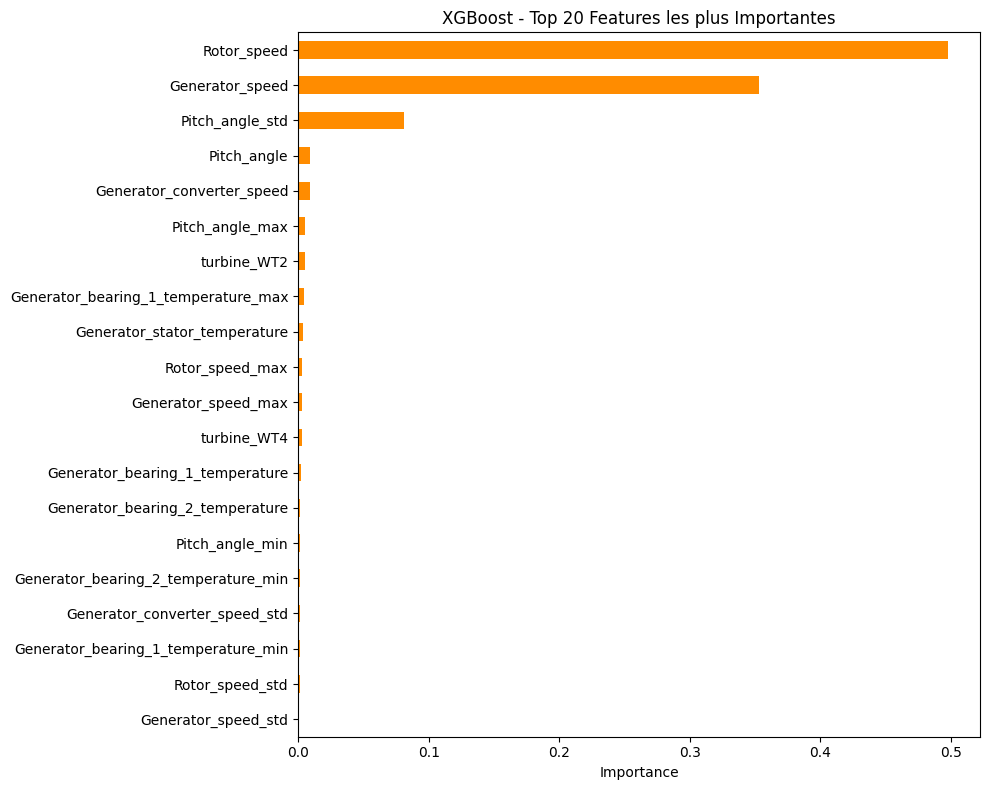

In [29]:
# Feature importance (XGBoost)
feat_imp_xgb = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
feat_imp_xgb.head(20).plot(kind='barh', color='darkorange')
plt.xlabel('Importance')
plt.title('XGBoost - Top 20 Features les plus Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

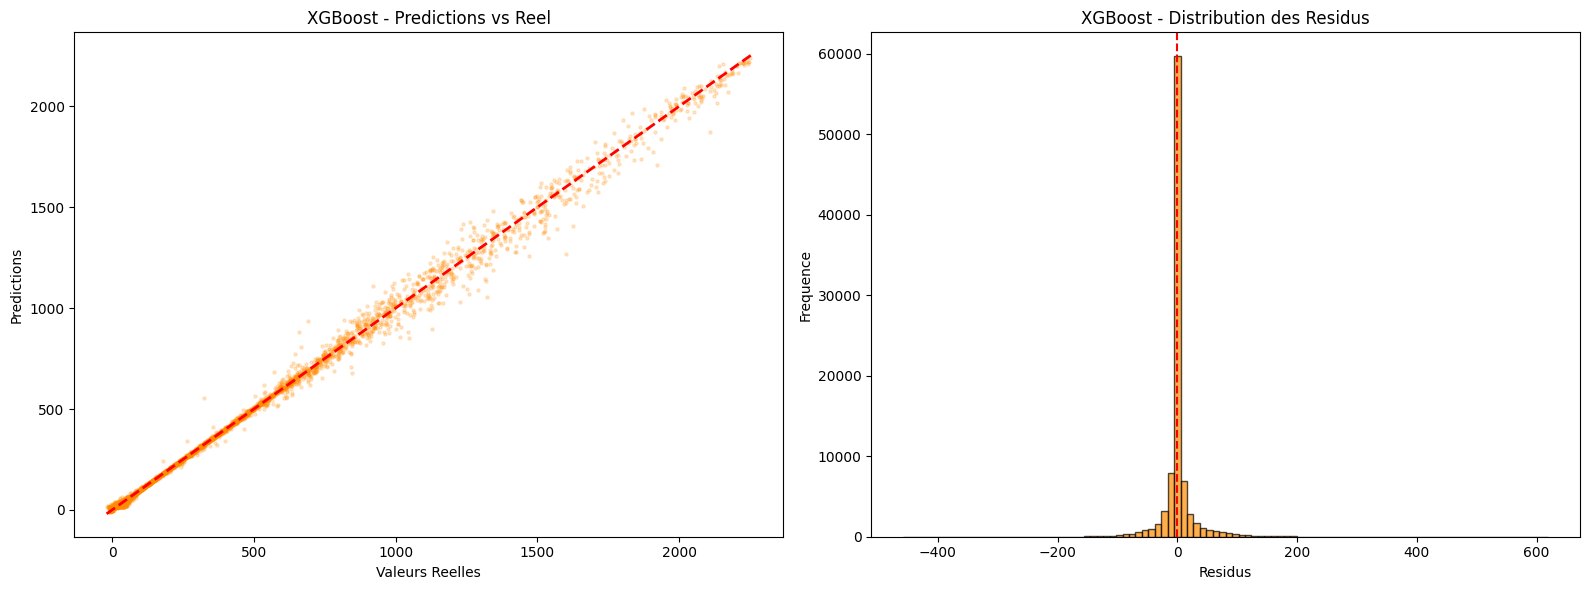

In [30]:
# Visualisation XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test[sample_idx], y_pred_xgb[sample_idx], alpha=0.2, s=5, color='darkorange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valeurs Reelles')
axes[0].set_ylabel('Predictions')
axes[0].set_title('XGBoost - Predictions vs Reel')

residuals_xgb = y_test - y_pred_xgb
axes[1].hist(residuals_xgb, bins=100, edgecolor='black', alpha=0.7, color='darkorange')
axes[1].set_xlabel('Residus')
axes[1].set_ylabel('Frequence')
axes[1].set_title('XGBoost - Distribution des Residus')
axes[1].axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()


## 5. Deep Learning

### 5.1 DNN :

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks


In [41]:
input_dim = X_train_scaled.shape[1]

def build_dnn_no_regularization(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(480, activation="relu"),
        layers.Dense(96, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),

        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="mse",
        metrics=["mae"]
    )

    return model

dnn_test = build_dnn_no_regularization(input_dim)
dnn_test.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 480)            │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 96)             │        46,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,769 (346.75 KB)

 Trainable params: 88,769 (346.75 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stop = callbacks.EarlyStopping(
    monitor="val_mae",
    patience=6,
    restore_best_weights=True
)
EPOCHS = 100
BATCH_SIZE = 512
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,
    patience=4,
    min_lr=1e-6
)

history_test = dnn_test.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 39661.3047 - mae: 85.1869 - val_loss: 97869.6094 - val_mae: 36.5530 - learning_rate: 5.0000e-04
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3867.1841 - mae: 32.1157 - val_loss: 64051.1680 - val_mae: 26.8823 - learning_rate: 5.0000e-04
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2601.1006 - mae: 25.4307 - val_loss: 50068.9219 - val_mae: 23.1607 - learning_rate: 5.0000e-04
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2225.6550 - mae: 23.2914 - val_loss: 33913.3086 - val_mae: 23.3293 - learning_rate: 5.0000e-04
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2005.2743 - mae: 22.0118 - val_loss: 44257.0469 - val_mae: 21.2503 - learning_rate: 5.0000e-04
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1844.5546 - mae: 21.0795 - val_loss: 42073.5078 - val_mae: 22.5666 - learning_rate: 5.0000e-04
Epoch 7/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 17

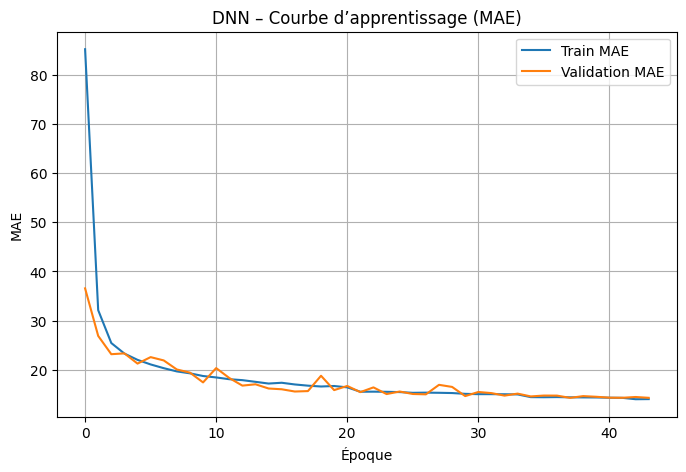

In [63]:
# Courbe d'apprentissage DNN - MAE
plt.figure(figsize=(8, 5))

plt.plot(history_test.history['mae'], label='Train MAE')
plt.plot(history_test.history['val_mae'], label='Validation MAE')

plt.xlabel('Époque')
plt.ylabel('MAE')
plt.title('DNN – Courbe d’apprentissage (MAE)')
plt.legend()
plt.grid(True)

plt.show()


Le modèle a bien appris la data de l'entrainement, et aussi à generaliser, ce qui a permis de bien perfomer sur la data de validation.

In [44]:
# Evaluation DNN 
y_pred_dnn_base = dnn_test.predict(X_test_scaled, batch_size=BATCH_SIZE).flatten()
evaluate_model('DNN Baseline', y_test, y_pred_dnn_base)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


{'MAE': 17.318572044563336,
 'RMSE': np.float64(38.675366282575695),
 'R2': 0.9942000428517698}

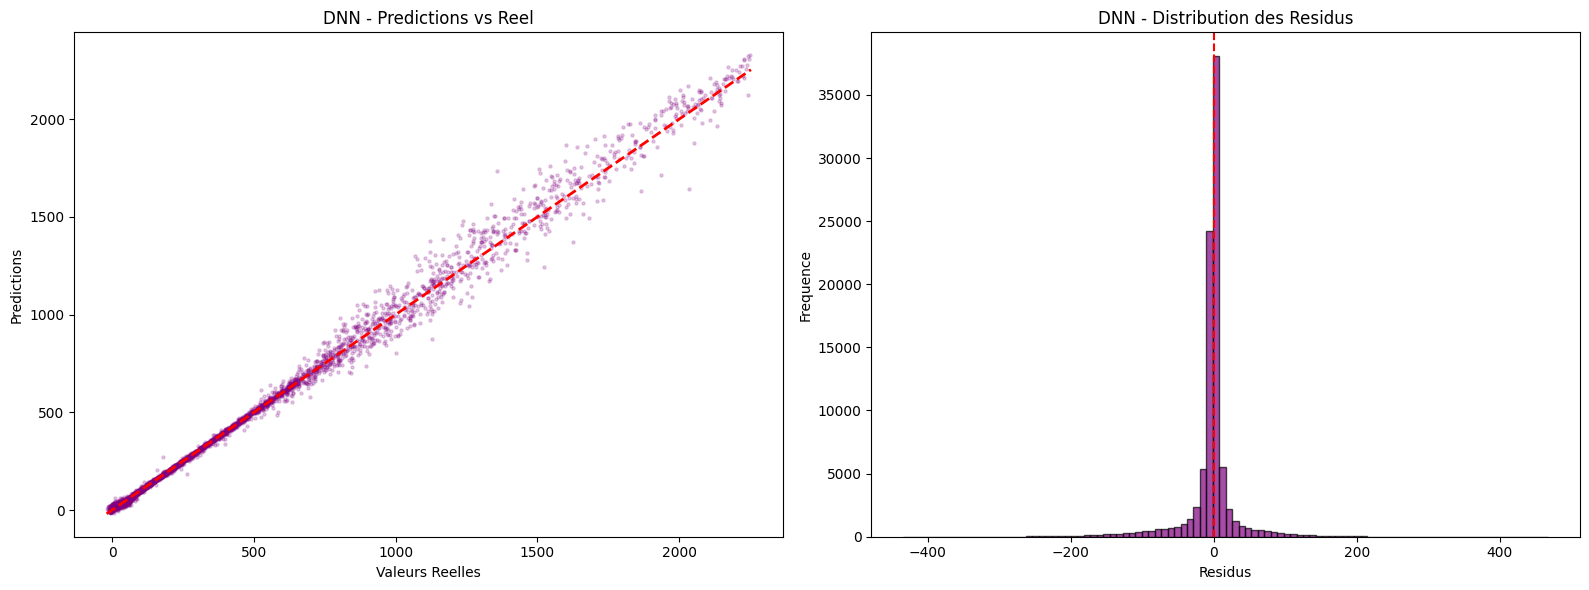

In [45]:
# Visualisation DNN 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test[sample_idx], y_pred_dnn_base[sample_idx], alpha=0.2, s=5, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valeurs Reelles')
axes[0].set_ylabel('Predictions')
axes[0].set_title('DNN - Predictions vs Reel')

residuals_dnn = y_test - y_pred_dnn_base
axes[1].hist(residuals_dnn, bins=100, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Residus')
axes[1].set_ylabel('Frequence')
axes[1].set_title('DNN - Distribution des Residus')
axes[1].axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

### 5.2 DNN Optimisé avec Keras Tuner

In [35]:
# Définition du modèle DNN pour la recherche d'hyperparamètres

def build_tunable_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    n_layers = hp.Int("n_layers", 2, 5)

    for i in range(n_layers):
        units = hp.Int(f"units_{i}", 32, 512, step=32)
        model.add(layers.Dense(units, activation="relu"))

        if hp.Boolean(f"batch_norm_{i}"):
            model.add(layers.BatchNormalization())

        dropout_rate = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))

    learning_rate = hp.Choice(
        "learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [ ]:
#Recherche d’hyperparamètres du DNN
BATCH_SIZE = 512 

tuner = kt.BayesianOptimization(
    build_tunable_model,
    objective=kt.Objective("val_mae", direction="min"),
    max_trials=2, # On a pris comme max trials 2 vu les ressources en local (CPU Uniquement)
    num_initial_points=5,
    directory="keras_tuner_dir",
    project_name="engie_dnn",
    overwrite=True
)

tuner_early_stop = callbacks.EarlyStopping(
    monitor="val_mae",
    patience=8,
    restore_best_weights=True
)

tuner.search(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[tuner_early_stop]
)


Trial 2 Complete [00h 02m 12s]
val_mae: 25.75636100769043

Best val_mae So Far: 15.390305519104004
Total elapsed time: 00h 05m 48s


In [46]:
# Récupération des meilleurs hyperparamètres

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_params = {
    "n_layers": best_hps.get("n_layers"),
    "learning_rate": best_hps.get("learning_rate"),
    "layers": [
        {
            "units": best_hps.get(f"units_{i}"),
            "dropout": best_hps.get(f"dropout_{i}"),
            "batch_norm": best_hps.get(f"batch_norm_{i}")
        }
        for i in range(best_hps.get("n_layers"))
    ]
}

best_params

{'n_layers': 5,
 'learning_rate': 0.001,
 'layers': [{'units': 288, 'dropout': 0.0, 'batch_norm': False},
  {'units': 128, 'dropout': 0.2, 'batch_norm': True},
  {'units': 32, 'dropout': 0.0, 'batch_norm': False},
  {'units': 32, 'dropout': 0.0, 'batch_norm': False},
  {'units': 32, 'dropout': 0.0, 'batch_norm': False}]}

In [47]:
# Modèle DNN Tuned – Entraînement final avec plus d'époques
BATCH_SIZE = 512 
EPOCHS = 200

best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_mae",
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_tuned = best_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 288)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,817 (261.00 KB)

 Trainable params: 66,561 (260.00 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 33354.3984 - mae: 74.2570 - val_loss: 4958.1719 - val_mae: 32.8897 - learning_rate: 0.0010
Epoch 2/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4088.2920 - mae: 35.9205 - val_loss: 4915.8110 - val_mae: 20.2951 - learning_rate: 0.0010
Epoch 3/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3613.6257 - mae: 33.3298 - val_loss: 5045.6714 - val_mae: 30.8904 - learning_rate: 0.0010
Epoch 4/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3350.4539 - mae: 31.7138 - val_loss: 5353.7935 - val_mae: 23.7733 - learning_rate: 0.0010
Epoch 5/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3284.6067 - mae: 31.3825 - val_loss: 3345.2964 - val_mae: 17.2453 - learning_rate: 0.0010
Epoch 6/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3000.3049 - mae: 29.7792 - val_loss: 3728.9658 - val_mae: 23.1086 - learning_rate: 0.0010
Epoch 7/200
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2923.1562 - mae: 29.3541 - val_l

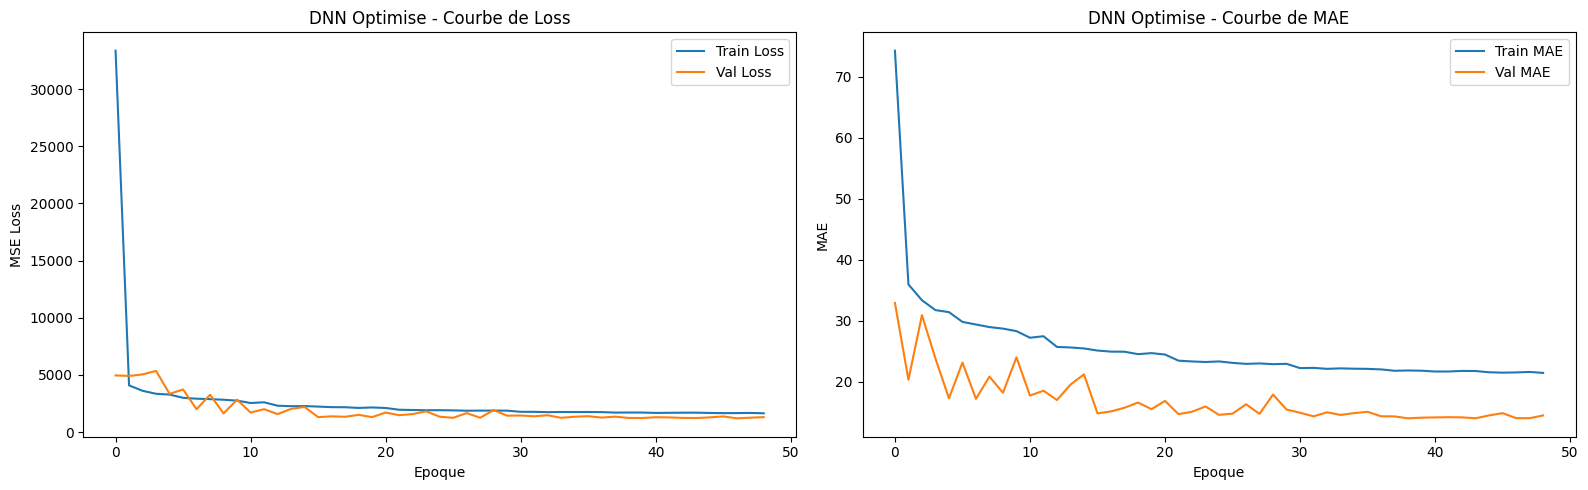

In [48]:
# Courbes d'apprentissage DNN Tuned
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history_tuned.history['loss'], label='Train Loss')
axes[0].plot(history_tuned.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoque')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('DNN Optimise - Courbe de Loss')
axes[0].legend()

axes[1].plot(history_tuned.history['mae'], label='Train MAE')
axes[1].plot(history_tuned.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoque')
axes[1].set_ylabel('MAE')
axes[1].set_title('DNN Optimise - Courbe de MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

Remarque : la dataset de validation a été moins complexe pour le modèle par rapport à la data de l'entrainement.

In [49]:
# Evaluation DNN Tuned
y_pred_dnn_tuned = best_model.predict(X_test_scaled, batch_size=BATCH_SIZE).flatten()
evaluate_model('DNN Optimise (Keras Tuner)', y_test, y_pred_dnn_tuned)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


{'MAE': 16.808817222998524,
 'RMSE': np.float64(36.23330751661285),
 'R2': 0.9949093659998919}

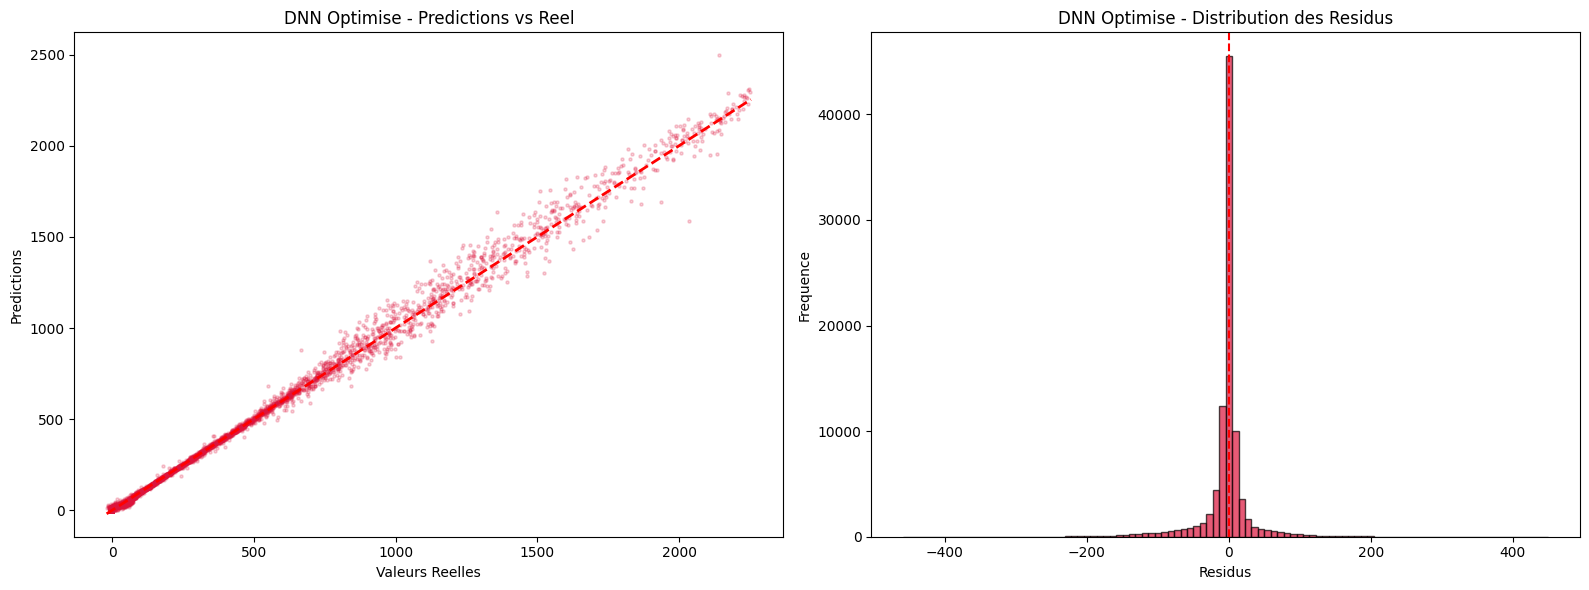

In [50]:
# Visualisation DNN Tuned
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test[sample_idx], y_pred_dnn_tuned[sample_idx], alpha=0.2, s=5, color='crimson')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valeurs Reelles')
axes[0].set_ylabel('Predictions')
axes[0].set_title('DNN Optimise - Predictions vs Reel')

residuals_dnn_tuned = y_test - y_pred_dnn_tuned
axes[1].hist(residuals_dnn_tuned, bins=100, edgecolor='black', alpha=0.7, color='crimson')
axes[1].set_xlabel('Residus')
axes[1].set_ylabel('Frequence')
axes[1].set_title('DNN Optimise - Distribution des Residus')
axes[1].axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

---
## 6. Comparaison des Modèles

In [51]:
# Tableau comparatif
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('MAE')
results_df.index.name = 'Modele'

print("=" * 70)
print("           COMPARAISON DES MODELES")
print("=" * 70)
print(results_df.to_string())
print("\n")
print(f"Meilleur modele (MAE) : {results_df.index[0]} avec MAE = {results_df.iloc[0]['MAE']:.6f}")

           COMPARAISON DES MODELES
                                  MAE        RMSE        R2
Modele                                                     
XGBoost                     12.477920   29.380689  0.996653
DNN Optimise (Keras Tuner)  16.808817   36.233308  0.994909
DNN Baseline                17.318572   38.675366  0.994200
Ridge Regression            91.887971  126.335504  0.938112


Meilleur modele (MAE) : XGBoost avec MAE = 12.477920


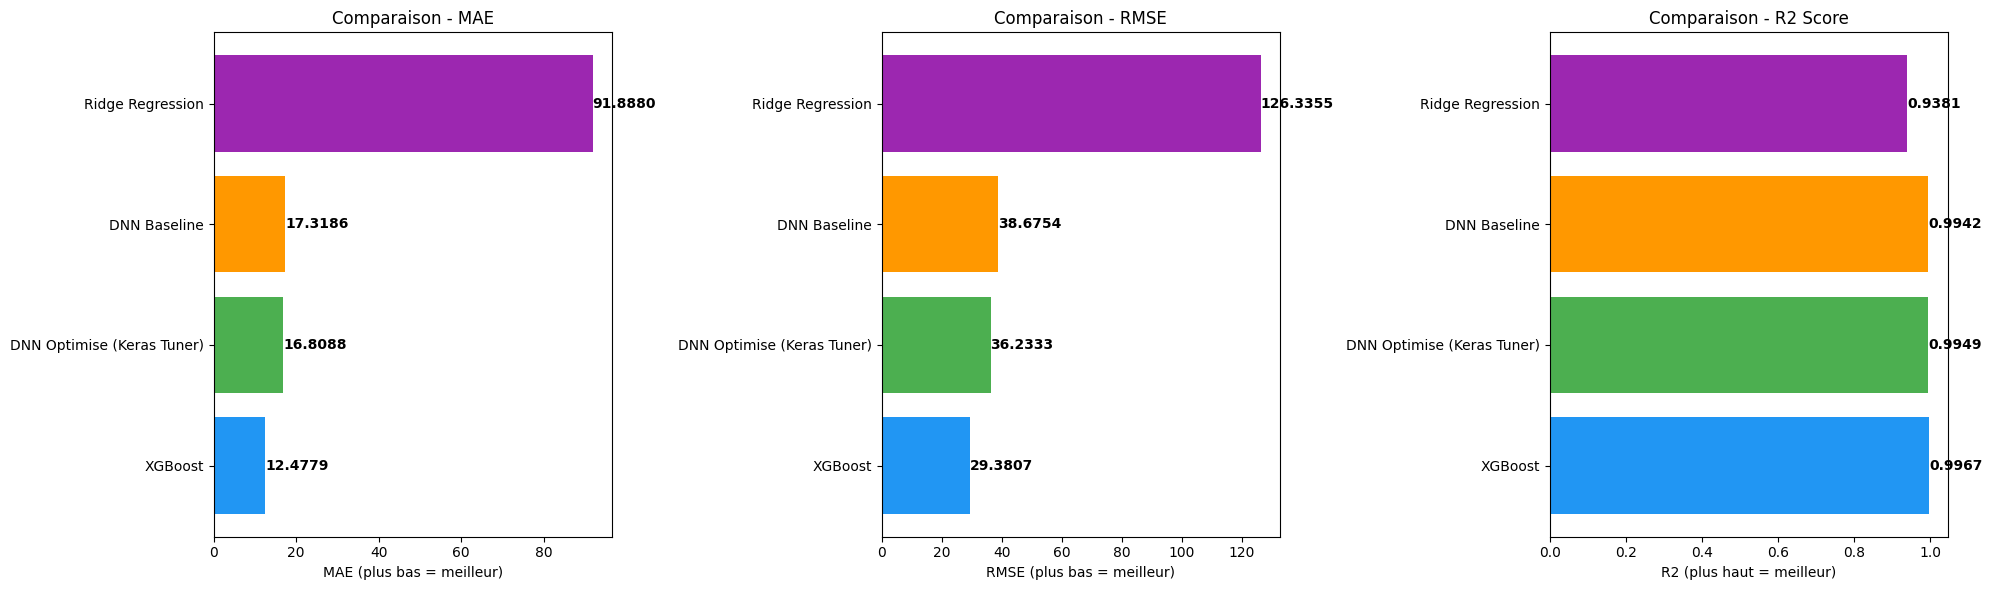

In [52]:
# Graphique comparatif MAE
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336']

# MAE
bars = axes[0].barh(results_df.index, results_df['MAE'], color=colors[:len(results_df)])
axes[0].set_xlabel('MAE (plus bas = meilleur)')
axes[0].set_title('Comparaison - MAE')
for bar, val in zip(bars, results_df['MAE']):
    axes[0].text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontweight='bold')

# RMSE
bars = axes[1].barh(results_df.index, results_df['RMSE'], color=colors[:len(results_df)])
axes[1].set_xlabel('RMSE (plus bas = meilleur)')
axes[1].set_title('Comparaison - RMSE')
for bar, val in zip(bars, results_df['RMSE']):
    axes[1].text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontweight='bold')

# R2
bars = axes[2].barh(results_df.index, results_df['R2'], color=colors[:len(results_df)])
axes[2].set_xlabel('R2 (plus haut = meilleur)')
axes[2].set_title('Comparaison - R2 Score')
for bar, val in zip(bars, results_df['R2']):
    axes[2].text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparaison_modeles.png', dpi=150, bbox_inches='tight')
plt.show()

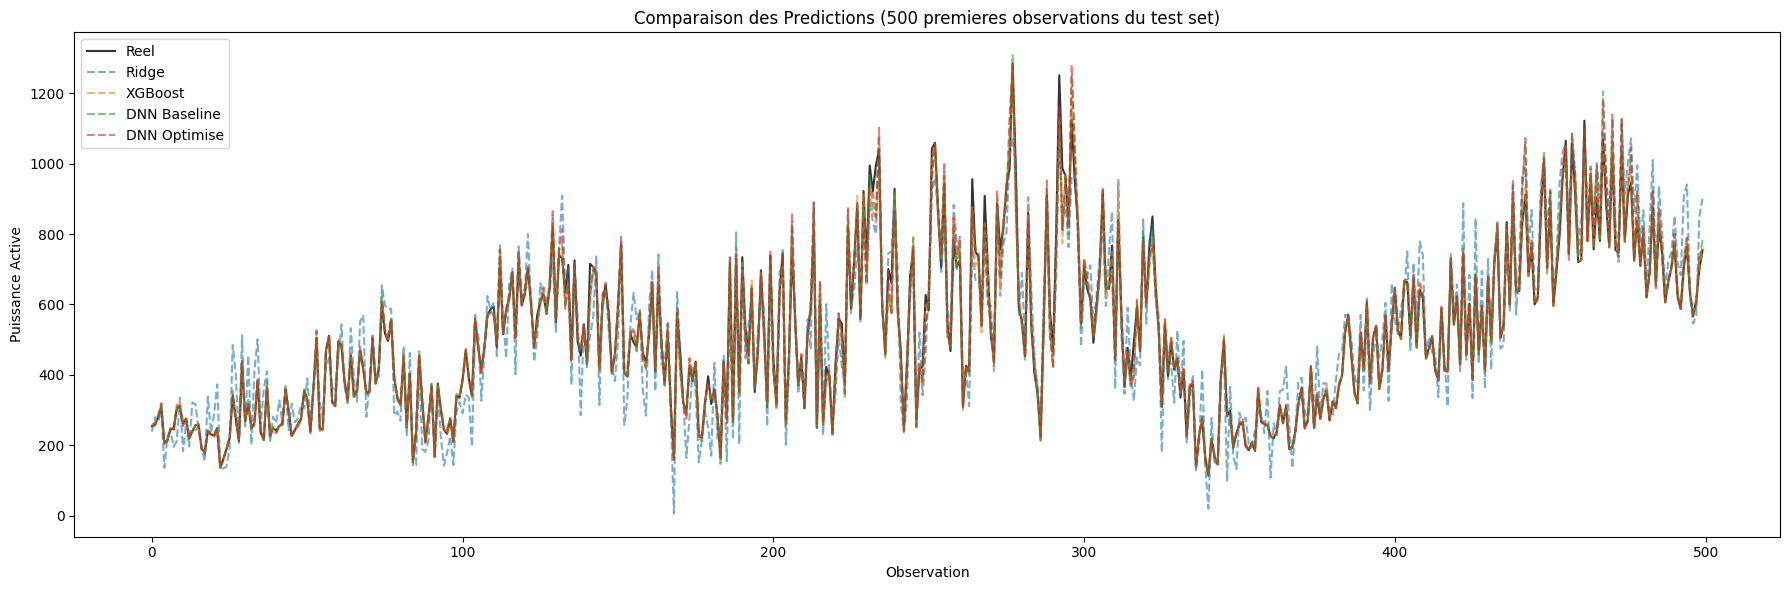

In [56]:
# Superposition des predictions de tous les modeles sur un sous-echantillon
n_show = 500
idx_show = np.arange(0, n_show)

plt.figure(figsize=(18, 6))
plt.plot(idx_show, y_test[idx_show], 'k-', linewidth=1.5, label='Reel', alpha=0.8)
plt.plot(idx_show, y_pred_ridge[idx_show], '--', alpha=0.6, label='Ridge')
plt.plot(idx_show, y_pred_xgb[idx_show], '--', alpha=0.6, label='XGBoost')
plt.plot(idx_show, y_pred_dnn_base[idx_show], '--', alpha=0.6, label='DNN Baseline')
plt.plot(idx_show, y_pred_dnn_tuned[idx_show], '--', alpha=0.6, label='DNN Optimise')

plt.xlabel('Observation')
plt.ylabel('Puissance Active')
plt.title('Comparaison des Predictions (500 premieres observations du test set)')
plt.legend()
plt.tight_layout()
plt.savefig('comparaison_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

In [58]:
# Analyse des erreurs par turbine (si les colonnes turbine sont presentes dans le test set)
test_with_preds = test_data.copy()
test_with_preds['pred_ridge'] = y_pred_ridge
test_with_preds['pred_xgb'] = y_pred_xgb
test_with_preds['pred_dnn_base'] = y_pred_dnn_base
test_with_preds['pred_dnn_tuned'] = y_pred_dnn_tuned

# Identifier la turbine via les colonnes one-hot
turbine_cols = [c for c in test_with_preds.columns if c.startswith('turbine_')]
test_with_preds['turbine'] = test_with_preds[turbine_cols].idxmax(axis=1).str.replace('turbine_', '')

print("\nMAE par turbine et par modele :\n")
for model_name, pred_col in [('Ridge', 'pred_ridge'),
                               ('XGBoost', 'pred_xgb'), ('DNN Baseline', 'pred_dnn_base'),
                               ('DNN Optimise', 'pred_dnn_tuned')]:
    mae_per_turb = test_with_preds.groupby('turbine').apply(
        lambda x: mean_absolute_error(x['TARGET'], x[pred_col])
    )
    print(f"{model_name:25s} -> {dict(mae_per_turb)}")


MAE par turbine et par modele :

Ridge                     -> {'WT1': np.float64(89.53151921584764), 'WT2': np.float64(87.05543946338648), 'WT3': np.float64(99.22468584504774), 'WT4': np.float64(91.74199150733548)}
XGBoost                   -> {'WT1': np.float64(12.975152119036268), 'WT2': np.float64(11.099874927928095), 'WT3': np.float64(14.381282942925315), 'WT4': np.float64(11.454744512322735)}
DNN Baseline              -> {'WT1': np.float64(16.099632550006344), 'WT2': np.float64(14.376863477529968), 'WT3': np.float64(22.53782251302181), 'WT4': np.float64(16.260249021247898)}
DNN Optimise              -> {'WT1': np.float64(16.03912570164047), 'WT2': np.float64(14.112730791617329), 'WT3': np.float64(20.496527882442376), 'WT4': np.float64(16.587570248845527)}


C:\Users\Smart Asus\AppData\Local\Temp\ipykernel_7080\118792506.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_turb = test_with_preds.groupby('turbine').apply(
C:\Users\Smart Asus\AppData\Local\Temp\ipykernel_7080\118792506.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_turb = test_with_preds.groupby('turbine').apply(
C:\Users\Smart Asus\AppData\Local\Temp\ipykernel_7080\118792506.py:16: F